# 2018-11-22 Supervised Learning et STDP
Le notebook de la veille est une non-supervisée à la K-means, qui force le ring à être topographique ET sparse, c'est merveilleux ça marche toubien.

La logique aurait été de faire le notebook d'aujourd'hui en premier mais une fois encore le plan du développement ne suit pas le plan de ce que mon cerveau veut bien coder :-) 

Dans ce notebook on va donc utiliser la STDP dans le ring et des cellulese externes qui connaissent le ground-truth pour imposer l'apprentissage de l'orientation, dans le but d'apprendre un pattern qui ressemblerait a une cellule complexe.

# Pas de topologie pour bien séparer les deux !

Pour le retrieval : http://neuralensemble.org/docs/PyNN/connections.html?highlight=stdpmechanism#accessing-weights-and-delays

# On cite le papier de bengio qui approxime la stdp comme une descente de gradient ?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
import Spiking_LGN as SpiLGN
import datetime
from tqdm import tqdm

import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


# On va tout regénerer dans le notebook pour bien controler
# Les MotionClouds, theta = pi/4 :

MC shape (64, 64, 128)


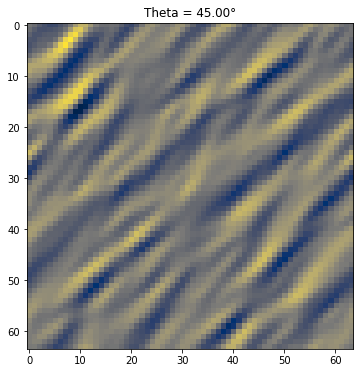

In [2]:
import MotionClouds as mc

mc_theta = np.pi/4
fx, fy, ft = mc.get_grids(64, 64, 128)

envelope = mc.envelope_gabor(fx, fy, ft,
                             V_X=1., V_Y=0., B_V=.1,
                             sf_0=.15, B_sf=.1,
                             theta=mc_theta, B_theta=np.pi/12, alpha=1.)

movie = mc.random_cloud(envelope)
movie = mc.rectif(movie)

print('MC shape', movie.shape)

plt.figure(figsize = (6,6))
plt.imshow(movie[:,:,4], cmap = plt.cm.cividis)
plt.title('Theta = %.2f°' % (mc_theta*180/np.pi))
plt.show()

# Les courants

In [3]:
video = movie
print('MotionCloud shape', video.shape)

output_currents = SpiLGN.input_to_currents(video=video, FPS=24., total_time=1000,
                                           distrib_size=8, safeguard_offset=5, random_shift=1, grid_res=3,
                                           N_theta=12, B_theta=15, sf_0=.05, B_sf=.5,
                                           on_thresh=0, off_thresh=0,
                                           filter_size=2., filter_res=.1,
                                           sampling_rate = 1,
                                           n_jobs=-1, backend='loky', mt_verbose=10)

load_arr = np.asarray(output_currents) #ça evite de réécrire tout le code

MotionCloud shape (64, 64, 128)
Video shape (64, 64, 128)
Frames per second: 24.0
Frame duration at 24.0 FPS: 41.67 ms
Video length inferred from fps: 6 s
FPS conversion sanity check passed !

Stimuli shape (64, 64, 1000)

Generating filters coordinates with gabors ..


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  8.9min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 13.1min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 13.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Done ! Generating currents from filters ..


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  9.7min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 15.1min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 15.2min finished


# Hyperparams de simulation

In [4]:
##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

syn_params = {'sparseness' : .05, # U.Arb.
             'w' : .01, # siemens ?,
             'delay' : 2. #ms
             }

stdp_params = {'tplus' : 20., #bi and po 98
              'tminus' : 20., #bi and po 98
              'aplus' : .05, #a calibrer avec le W synaptique
              'aminus' : .05,
               'wmin' : 0, #silent synapse at the very least
               'wmax' : .5 #50 times potentation at max (not very biolike)
              }
gain = .05
injection_sampling_rate = 1
total_time = 1000

total_neurons = load_arr.shape[0] * load_arr.shape[1]

current_times = np.linspace(0,total_time,total_time/injection_sampling_rate)
print('Total neurons', total_neurons)

Total neurons 588


/home/hugo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [ ]:
#############
# Simulation#
#############
sim.setup(timestep=0.1)

simple_cells = sim.Population(total_neurons, sim.IF_cond_alpha(**neuron_params),
                        initial_values={"v": neuron_params["v_reset"]}, label="simple_cells")

stdp_connexion = sim.STDPMechanism(
                    weight=syn_params['w'],
                    delay=syn_params['delay'],
                    timing_dependence=sim.SpikePairRule(tau_plus=stdp_params['tplus'], 
                                                        tau_minus=stdp_params['tminus'],
                                                        A_plus=stdp_params['aplus'],
                                                        A_minus=stdp_params['aminus']),
                    weight_dependence=sim.AdditiveWeightDependence(w_min=stdp_params['wmin'],
                                                                   w_max=stdp_params['wmax']),
                    dendritic_delay_fraction=1.)

neuron_iterator = 0

with tqdm(total = total_neurons, desc = 'LGN is communicating with V1') as progress_bar :
    for orientations in load_arr:
        for positions in orientations :
            #injecting all ON LGN current
            for inputs in positions[0]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #injecting all OFF LGN current
            for inputs in positions[1]:
                current_level = inputs[::injection_sampling_rate]
                current_level = np.asarray(current_level)

                current_input = sim.StepCurrentSource(times = current_times,
                                                 amplitudes = current_level*gain)
                current_input.inject_into(simple_cells[neuron_iterator:neuron_iterator+1])
                current_input.record()
                
            #moving on to next V1 neuron 
            neuron_iterator +=1
            progress_bar.update(1)
            
simple_cells.record(['spikes', 'v'])
sim.run(total_time)
sim.end()

LGN is communicating with V1: 100%|██████████| 588/588 [01:43<00:00,  5.69it/s]

In [ ]:
v1_data = simple_cells.get_data().segments[0]
v1_voltage = v1_data.analogsignals[0]

In [ ]:
#NEO's arrays are weirdly shaped, we have to transpose them
fig, ax = plt.subplots(figsize = (16,10))
colors = plt.cm.autumn(np.linspace(.1, 1, 49))

neuron_iterator = 0
orientation = 3

for positions in load_arr[orientation]:
    index = neuron_iterator + (orientation * load_arr.shape[0]) #we're skipping the other positions

    ax.plot(v1_voltage.T[index],
            color=colors[neuron_iterator],
            alpha = 1)
        
    for spikes in np.asarray(v1_data.spiketrains[index]):
        plt.plot([ spikes*10,spikes*10 ] , [v1_voltage.T[index][int(spikes)] , 20],
        color=colors[neuron_iterator])

    neuron_iterator +=1


plt.title("Spikes for neurons preferring theta = %s" % ((np.pi/12)*3*180/np.pi))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Blues(np.linspace(.4, 1, 12))

neuron_iterator = 0
total_spikes, total_spiking_neurons = 0, 0


for i,orientations in enumerate(load_arr):
    for positions in orientations:
        ax.scatter(v1_data.spiketrains[neuron_iterator],
                   np.full_like(v1_data.spiketrains[neuron_iterator], neuron_iterator),
                   s=5, color=colors[i],
                   label='%.1f°' % (i*(np.pi/12)*180/np.pi) if neuron_iterator%25 ==0 else '')
        
        total_spikes += len(v1_data.spiketrains[neuron_iterator])
        if len(v1_data.spiketrains[neuron_iterator]) > 0:
            total_spiking_neurons += 1
            
        neuron_iterator += 1

plt.ylim(-5, total_neurons)
plt.xlim(150, total_time)

plt.ylabel('Neuron index')
plt.xlabel('Time (ms)')
handles, labels = ax.get_legend_handles_labels()
#handles[::-1], labels[::-1],
plt.legend(markerscale=3, title='Preferred orientation\n    for one position',
           ncol=2)

plt.title('''
            Mean population FR : %.2f Hz''' % (total_spikes/total_spiking_neurons))

#plt.savefig('./figs/2018_11_16_Ring_spikes_nosynapses_orientation.pdf', format = 'pdf', dpi = 200, bbox_inches = 'tight')
plt.show()

In [ ]:
#firing rates for all neurons, excluding the initialisation artifact
fr_list = []
for neuron_fr in v1_data.spiketrains :
    fr_list.append(len(np.where(neuron_fr>150)[0]))
    
len(fr_list)

In [ ]:
# We split for each orientation
k = np.split(np.asarray(fr_list), 12)
k

In [ ]:
#wrong axis ?? ask laurent
plt.plot(np.mean(k, axis = 0))

In [ ]:
#that seems more like it
plt.plot(np.mean(k, axis = 1))
plt.xlabel('Thetas')
plt.ylabel('Mean FR')

In [ ]:
from lmfit.models import GaussianModel

x = np.linspace(0, 6,6)
y = np.asarray(np.mean(k, axis = 1)[:6])

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

def fit_curve(xs, sigma, center, amplitude):
    return amplitude/(sigma *np.sqrt(2*np.pi)) * np.exp( (-(xs-center)**2)/ (2*sigma**2)) 

gaussian_distrib1 = fit_curve(xs=np.linspace(0, 6, 100),
                             sigma=out.best_values['sigma'],
                             center=out.best_values['center'],
                             amplitude=out.best_values['amplitude'])

#####################################################################################################
x = np.linspace(7, 12,6)
y = np.asarray(np.mean(k, axis = 1)[6:])

mod = GaussianModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=0.25))

def fit_curve(xs, sigma, center, amplitude):
    return amplitude/(sigma *np.sqrt(2*np.pi)) * np.exp( (-(xs-center)**2)/ (2*sigma**2)) 

gaussian_distrib2 = fit_curve(xs=np.linspace(6, 12, 100),
                             sigma=out.best_values['sigma'],
                             center=out.best_values['center'],
                             amplitude=out.best_values['amplitude'])

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(np.mean(k, axis = 1), '.b')
plt.plot(np.linspace(0,6,100),gaussian_distrib1, color = 'black')
plt.plot(np.linspace(6,12,100),gaussian_distrib2, color = 'black')


plt.title('Mean firing rate for each orientation, described by two gaussians\nGround truth = 4')

plt.xlabel('Orientation (theta)')
plt.ylabel('Meaniring rate (Hz)')
#plt.savefig('./figs/2018_11_22_Orientation_curves.pdf', dpi = 200, format = 'pdf', bbox_inches = 'tight')
plt.show()